<a href="https://colab.research.google.com/github/alirezash97/Cardio/blob/master/HeartBeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"alirezashafaei97","key":"9cb262aa0c5658ffc4eb45857c41903c"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d shayanfazeli/heartbeat -p /content
!unzip /content/heartbeat.zip -d /content/heartbeat

In [1]:
import pandas as pd
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import (Input, Dense, LeakyReLU, Softmax, InputLayer, concatenate, Conv1D, MaxPool1D, Add, MaxPooling1D
 , Flatten, Dropout, ReLU, BatchNormalization, GlobalAveragePooling1D)
from keras.utils.np_utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from random import uniform 
import random


from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix


Using TensorFlow backend.


In [0]:
train_df=pd.read_csv('/content/heartbeat/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/heartbeat/mitbih_test.csv',header=None)

In [0]:
# train_df = train_df[:186].astype('float16')
# test_df = test_df[:186].astype('float16')

In [52]:
train_df[187]=train_df[187].astype(int)
counter=train_df[187].value_counts()
print(counter)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [0]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=10000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=10000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=10000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=10000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=10000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [0]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [55]:
equilibre=train_df[187].value_counts()
print(equilibre)

4    10000
3    10000
2    10000
1    10000
0    10000
Name: 187, dtype: int64


In [56]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
23029,1.000000,0.791925,0.611801,0.307453,0.130435,0.055901,0.118012,0.142857,0.161491,0.142857,0.161491,0.158385,0.173913,0.161491,0.180124,0.167702,0.192547,0.189441,0.211180,0.201863,0.232919,0.236025,0.270186,0.279503,0.307453,0.316770,0.354037,0.354037,0.397516,0.406832,0.456522,0.450311,0.447205,0.397516,0.354037,0.307453,0.291925,0.245342,0.248447,0.226708,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0
74608,1.000000,0.971014,0.289855,0.000000,0.091787,0.120773,0.053140,0.125604,0.217391,0.169082,0.154589,0.207729,0.328502,0.367150,0.357488,0.362319,0.386473,0.400966,0.362319,0.357488,0.400966,0.391304,0.367150,0.376812,0.405797,0.425121,0.415459,0.449275,0.502415,0.516908,0.516908,0.541063,0.570048,0.589372,0.608696,0.608696,0.642512,0.608696,0.574879,0.545894,...,0.328502,0.328502,0.294686,0.304348,0.328502,0.328502,0.299517,0.280193,0.323671,0.31401,0.318841,0.323671,0.328502,0.323671,0.309179,0.318841,0.318841,0.299517,0.318841,0.294686,0.31401,0.338164,0.328502,0.323671,0.333333,0.304348,0.31401,0.323671,0.342995,0.338164,0.318841,0.31401,0.352657,0.347826,0.285024,0.285024,0.31401,0.347826,0.342995,1
78364,1.000000,0.967675,0.687174,0.286757,0.162669,0.172054,0.133472,0.117831,0.133472,0.136601,0.118874,0.103233,0.096976,0.093848,0.079249,0.068822,0.064651,0.050052,0.037539,0.026069,0.016684,0.012513,0.006257,0.000000,0.007299,0.015641,0.020855,0.038582,0.065693,0.098019,0.118874,0.139729,0.160584,0.183525,0.191867,0.197080,0.204380,0.212722,0.211679,0.207508,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2
80617,0.966216,1.000000,0.603041,0.253378,0.173986,0.140203,0.114865,0.104730,0.091216,0.096284,0.081081,0.087838,0.072635,0.076014,0.060811,0.070946,0.059122,0.054054,0.037162,0.043919,0.033784,0.037162,0.027027,0.028716,0.035473,0.054054,0.064189,0.086149,0.091216,0.119932,0.140203,0.170608,0.175676,0.180743,0.165541,0.182432,0.173986,0.172297,0.157095,0.167230,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,3
83287,0.743922,0.648298,0.542950,0.410049,0.280389,0.149109,0.082658,0.022690,0.000000,0.008104,0.082658,0.170178,0.309562,0.361426,0.434360,0.491086,0.555916,0.578606,0.609400,0.615883,0.633712,0.635332,0.654781,0.656402,0.680713,0.680713,0.703404,0.701783,0.726094,0.734198,0.761750,0.771475,0.800648,0.811994,0.839546,0.850891,0.871961,0.883306,0.904376,0.899514,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,4


In [0]:
# del c

In [0]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

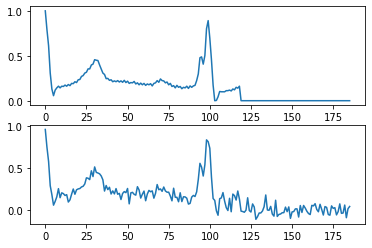

In [58]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [0]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [0]:
train_df = train_df.astype('float16')
test_df = test_df.astype('float16')

X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
# X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
# X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [61]:
print(X_train.shape)
print(X_test.shape)

(50000, 186)
(21892, 186)


In [0]:
# data augmentation

def augmetation(X_train, y_train, chance):

  augment_number = 0
  XF_train = np.zeros((X_train.shape[0]*2, X_train.shape[1]))
  yf_train = np.zeros((y_train.shape[0]*2, y_train.shape[1]))
  pointer = 0
  for index, row in enumerate(X_train):

    XF_train[pointer, :] = row
    yf_train[pointer, :] = y_train[index, :]
    pointer += 1

    rand_num = random.uniform(0, 1)      
    if chance > rand_num :

      augment_number += 1
      noise = np.random.normal(0,0.05,186)
      new_signal = row + noise  
      XF_train[pointer, :] = new_signal
      yf_train[pointer, :] = y_train[index, :]
      pointer += 1

      filled = X_train.shape[0] + augment_number
      XFF_train = XF_train[:filled, :]
      yff_train = yf_train[:filled, :]

    
  return XFF_train, yff_train


In [0]:
X_train, y_train = augmetation(X_train, y_train, 0.1)

In [0]:
# periodic signal extend 

import pywt

XF_train = np.zeros((X_train.shape[0], 9000))
XF_test = np.zeros((X_test.shape[0], 9000))


for index, row in enumerate(X_train):
  XF_train[index, :] = pywt.pad(row, 4407, 'periodic')


for index, row in enumerate(X_test):
  XF_test[index, :] = pywt.pad(row, 4407, 'periodic')

In [0]:
XF_train = XF_train.reshape((XF_train.shape[0], 9000, 1))
XF_test = XF_test.reshape((XF_test.shape[0], 9000, 1))

In [66]:
print("X_train : ", XF_train.shape)
print("Y_train : ", y_train.shape)
print("X_test : ", XF_test.shape)
print("Y_test : ", y_test.shape)

X_train :  (54991, 9000, 1)
Y_train :  (54991, 5)
X_test :  (21892, 9000, 1)
Y_test :  (21892, 5)


In [0]:
X_input = Input(shape=(9000, 1))
Conv = Conv1D(filters=64, kernel_size=5, strides=3)(X_input)


### step 1 

Conv1_1 = Conv1D(filters=64, kernel_size=9, strides=1, padding='same')(Conv)
Bn1_1 = BatchNormalization()(Conv1_1)
Act1_1 = LeakyReLU()(Bn1_1)
Conv1_2 = Conv1D(filters=64, kernel_size=7, strides=1, padding='same')(Act1_1)
Bn1_2 = BatchNormalization()(Conv1_2)
Act1_2 = LeakyReLU()(Bn1_2)
DO1_1 = Dropout(0.2)(Act1_2)
Conv1_3 = Conv1D(filters=64, kernel_size=9, strides=1, padding='same')(DO1_1)
Bn1_3 = BatchNormalization()(Conv1_3)
shortcut1_1 = Add()([Bn1_3, Conv])
Bn1_4 = BatchNormalization()(shortcut1_1)
Act1_3 = LeakyReLU()(Bn1_4)
##### auxiliary
Conv1_4 = Conv1D(filters=128, kernel_size=7, strides=3, padding='same')(Act1_3)
Bn1_5 = BatchNormalization()(Conv1_4)
Act1_4 = LeakyReLU()(Bn1_5)
###############
Max1_1 = MaxPooling1D(pool_size=5, strides=2)(Act1_4)


## step 2

Conv2_1 = Conv1D(filters=256, kernel_size=3, strides=1, padding='same')(Max1_1)
Bn2_1 = BatchNormalization()(Conv2_1)
Act2_1 = LeakyReLU()(Bn2_1)
Conv2_2 = Conv1D(filters=256, kernel_size=5, strides=1, padding='same')(Act2_1)
Bn2_2 = BatchNormalization()(Conv2_2)
Act2_2 = LeakyReLU()(Bn2_2)
DO2_1 = Dropout(0.2)(Act2_2)
Conv2_3 = Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(DO2_1)
Bn2_3 = BatchNormalization()(Conv2_3)
shortcut2_1 = Add()([Bn2_3, Max1_1])
Bn2_4 = BatchNormalization()(shortcut2_1)
Act2_3 = LeakyReLU()(Bn2_4)
##### auxiliary
Conv2_4 = Conv1D(filters=512, kernel_size=7, strides=2, padding='same')(Act2_3)
Bn2_5 = BatchNormalization()(Conv2_4)
Act2_4 = LeakyReLU()(Bn2_5)
###############
Max2_1 = MaxPooling1D(pool_size=5, strides=3)(Act2_4)



Flat1 = Flatten()(Max2_1)

D1 = Dense(256)(Flat1)
A6 = LeakyReLU()(D1)
D_O = Dropout(0.15)(A6)
D2 = Dense(128)(D_O)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=X_input, outputs=A7)

model.summary()




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2999, 64)     384         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2999, 64)     36928       conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2999, 64)     256         conv1d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1719,
    decay_rate=0.7)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [0]:
# overfitting so augment more data and decrease initial learning rate to 1e-3

# compile model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Early Stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
history = model.fit(XF_train, y_train, epochs=7, batch_size=64, validation_data=(XF_test, y_test), callbacks=[es_callback])

Epoch 1/7
860/860 [==============================] - 7778s 9s/step - loss: 3.8281 - accuracy: 0.6426 - val_loss: 0.3030 - val_accuracy: 0.9246
Epoch 2/7
860/860 [==============================] - 8050s 9s/step - loss: 0.3551 - accuracy: 0.8814 - val_loss: 0.3695 - val_accuracy: 0.8722
Epoch 3/7
860/860 [==============================] - 8033s 9s/step - loss: 0.2365 - accuracy: 0.9176 - val_loss: 0.2716 - val_accuracy: 0.9079
Epoch 4/7
860/860 [==============================] - 8097s 9s/step - loss: 0.2672 - accuracy: 0.9205 - val_loss: 0.2414 - val_accuracy: 0.9203
Epoch 5/7


In [0]:
# evaluate the model
scores = model.evaluate(XF_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# save model and architecture to single file
model.save("/content/drive/My Drive/Cardio/HeartBeat.h5")

NameError: ignored

In [0]:
/*

In [0]:
from google.colab import drive
drive.mount('/content/drive')